In [201]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split 
import pandas as pd
import math

from utils import *

In [202]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Load the dataset

In [203]:
(x_train_valid_1, y_train_valid_1), (x_test, y_test) = load_dataset_from_gz("gz")

x_train_valid_1 = np.transpose(x_train_valid_1, (0, 2, 1))
x_test = np.transpose(x_test, (0, 2, 1))

x_train_valid_1.shape

(112800, 28, 28)

In [204]:
x_train_valid_2, y_train_valid_2 = load_dataset_from_images("images")
x_train_valid_2.shape

(216, 28, 28)

In [205]:
x_train_valid, y_train_valid = concat_datasets(x_train_valid_1, y_train_valid_1, x_train_valid_2, y_train_valid_2)
x_train_valid.shape

(113016, 28, 28)

In [206]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, train_size=0.8, random_state=42)

In [207]:
class_names = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F'}
class_labels = list(class_names.keys())

x_train, y_train = filter_dataset_by_labels(x_train, y_train, class_labels)
x_valid, y_valid = filter_dataset_by_labels(x_valid, y_valid, class_labels)
x_test, y_test = filter_dataset_by_labels(x_test, y_test, class_labels)

In [208]:
x_train.shape, x_valid.shape, x_test.shape

((30887, 28, 28), (7729, 28, 28), (6400, 28, 28))

In [209]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [210]:
def preprocess_image(image):
    def crop_zero_border(arr):
        # Find rows and columns where all elements are zero
        row_mask = np.all(arr == 0, axis=1)
        col_mask = np.all(arr == 0, axis=0)
    
        # Find the first and last non-zero rows and columns
        first_row = np.argmax(~row_mask)
        last_row = arr.shape[0] - 1 - np.argmax(np.flip(~row_mask))
        first_col = np.argmax(~col_mask)
        last_col = arr.shape[1] - 1 - np.argmax(np.flip(~col_mask))
    
        # Crop the array
        cropped_arr = arr[first_row:last_row + 1, first_col:last_col + 1]
    
        return cropped_arr
    
    def make_square(image):
        # Determine dimensions of the image
        height, width = image.shape
    
        # Find the maximum dimension
        max_dim = max(height, width)
    
        # Create a square image with zeros
        square_image = np.zeros((max_dim, max_dim), dtype=np.uint8)
    
        # Calculate the starting position to place the image
        start_height = (max_dim - height) // 2
        start_width = (max_dim - width) // 2
    
        # Place the image onto the square image
        square_image[start_height:start_height+height, start_width:start_width+width] = image
    
        return square_image
    
    def add_padding(image, padding_ratio):
        rows, cols = image.shape
    
        # Calculate the padding size
        padding_rows = int(rows * padding_ratio)
        padding_cols = int(cols * padding_ratio)
    
        # Create a black canvas with padding
        padded_image = np.zeros((rows + 2 * padding_rows, cols + 2 * padding_cols), dtype=np.uint8)
    
        # Calculate the offset for the image
        x_offset = padding_cols
        y_offset = padding_rows
    
        # Copy the image to the center of the canvas
        padded_image[y_offset:y_offset+rows, x_offset:x_offset+cols] = image
    
        return padded_image
    
    image = image.numpy()
    
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    image = crop_zero_border(image)
    image = make_square(image)
    image = add_padding(image, 0.2)

    image = cv2.resize(image, (28, 28))
    image = (image / 255).astype(np.float32)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

train_ds = train_ds.map(lambda x, y: (tf.py_function(preprocess_image, [x], tf.float32), y))
valid_ds = valid_ds.map(lambda x, y: (tf.py_function(preprocess_image, [x], tf.float32), y))
test_ds = test_ds.map(lambda x, y: (tf.py_function(preprocess_image, [x], tf.float32), y))

In [211]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [212]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 40000

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [213]:
import matplotlib as mpl
from matplotlib import pyplot as plt

def get_sample(ds, sample_count=25):
    ds = ds.unbatch().batch(sample_count)
    images, labels = iter(ds).next()
    return images.numpy(), labels.numpy()


def show_sample(images, labels):
    sample_count = len(images)
    grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
    plt.figure(figsize=(2 * grid_count, 2 * grid_count))
    for i in range(sample_count):
        plt.subplot(grid_count, grid_count, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=mpl.colormaps["binary"])
        plt.xlabel(labels[i])
    plt.show()

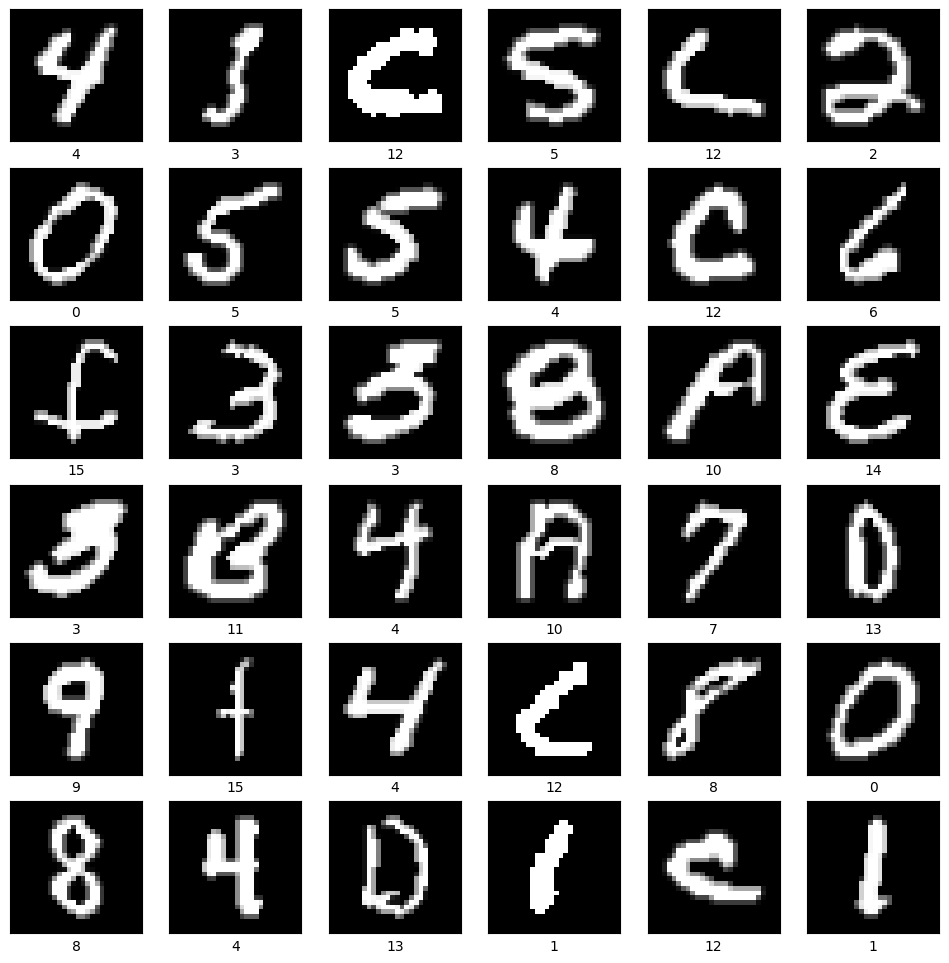

In [214]:
show_sample(*get_sample(train_ds, 36))

### Train the model

In [217]:
from tensorflow.keras import layers

model = keras.models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=[28, 28, 3]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))

In [218]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

In [219]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [220]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=[
    early_stopping_cb
])

Epoch 1/100
483/483 [==============================] - 21s 26ms/step - loss: 1.0650 - accuracy: 0.6603 - val_loss: 0.2973 - val_accuracy: 0.9074
Epoch 2/100
483/483 [==============================] - 19s 25ms/step - loss: 0.3735 - accuracy: 0.8816 - val_loss: 0.1706 - val_accuracy: 0.9476
Epoch 3/100
483/483 [==============================] - 20s 25ms/step - loss: 0.2784 - accuracy: 0.9130 - val_loss: 0.1402 - val_accuracy: 0.9578
Epoch 4/100
483/483 [==============================] - 19s 24ms/step - loss: 0.2429 - accuracy: 0.9235 - val_loss: 0.1228 - val_accuracy: 0.9625
Epoch 5/100
483/483 [==============================] - 18s 23ms/step - loss: 0.2173 - accuracy: 0.9302 - val_loss: 0.1106 - val_accuracy: 0.9665
Epoch 6/100
483/483 [==============================] - 18s 23ms/step - loss: 0.2043 - accuracy: 0.9368 - val_loss: 0.1045 - val_accuracy: 0.9671
Epoch 7/100
483/483 [==============================] - 18s 23ms/step - loss: 0.1874 - accuracy: 0.9405 - val_loss: 0.0977 - val_ac

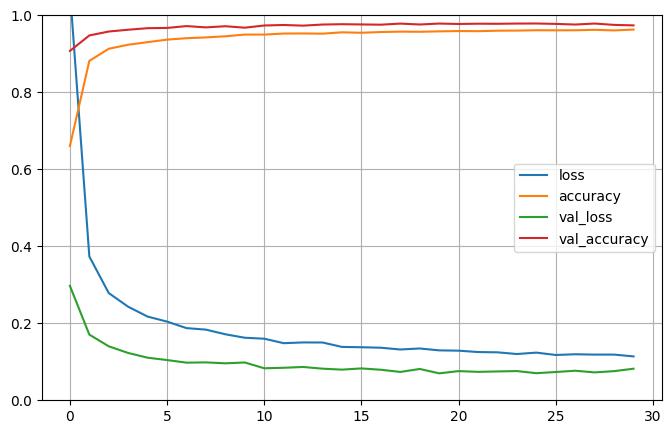

In [221]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [222]:
model.evaluate(test_ds)

100/100 [==============================] - 2s 20ms/step - loss: 0.0658 - accuracy: 0.9787


[0.06576862931251526, 0.9787499904632568]

### Using the model to make predictions

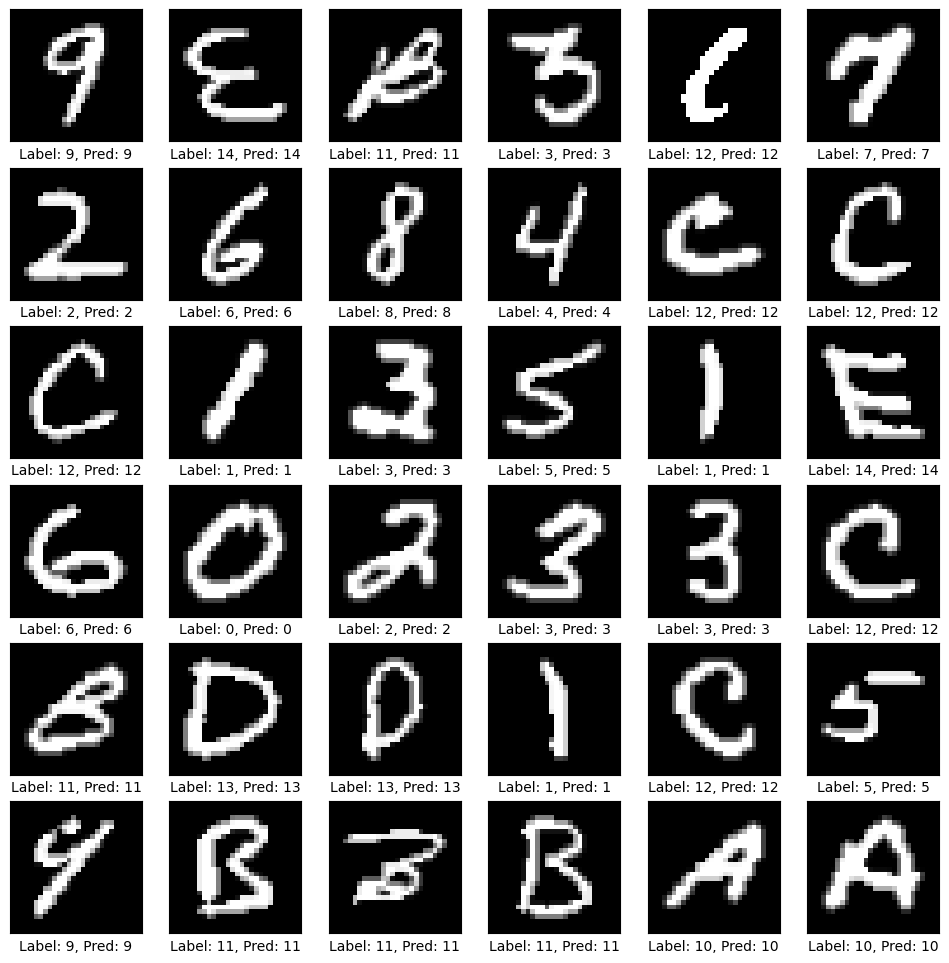

In [223]:
x, y = get_sample(test_ds, 36)
predictions = model.predict(x, verbose=0)
show_sample(x, [f"Label: {y[i]}, Pred: {np.argmax(v)}" for i, v in enumerate(predictions)])

### Convert the Keras model to TensorFlow Lite

In [224]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\artem\AppData\Local\Temp\tmpv2d9q4gc\assets


INFO:tensorflow:Assets written to: C:\Users\artem\AppData\Local\Temp\tmpv2d9q4gc\assets


In [225]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Jigsaw Sudoku image classifier"
model_meta.description = "Classification of Jigsaw Sudoku cell characters, including digits 0-9 as well as letters A-F (e.g. for Hexadoku)."
model_meta.version = "v1"
model_meta.author = "Artem259"
model_meta.license = ""

In [226]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "image"
input_meta.description = (f"Input image to be classified. The expected image is 28 x 28, with one channel (greyscale). "
                          "Each value in the tensor is a single byte between 0 and 255.")
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [0]
input_normalization.options.std = [255]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [227]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the character labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats

In [228]:
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labels.txt")
label_file.description = "Labels for characters that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [229]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [230]:
populator = _metadata.MetadataPopulator.with_model_file("model.tflite")
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["labels.txt"])
populator.populate()